In [2]:
import os
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy import ndimage
import pywt

In [3]:
# Utils

# Importer une image
def import_image(filename):
    image = ski.io.imread(filename)
    return np.array(image)

# Afficher une image
def display_image(image, title):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Calculer le PSNR entre deux images
def psnr(original_image, processed_image):
    original_image = original_image.astype(np.float64)
    processed_image = processed_image.astype(np.float64)
    mse = np.mean((original_image - processed_image) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr_value


In [4]:
# Transformée en ondelettes de Haar

# Appliquer la transformée
def apply_wavelet_transform(image, wavelet='haar'):
    coeffs = pywt.wavedec2(image, wavelet, level=2)
    return coeffs

# Normaliser les coefficients pour l'enregistrement
def normalize_coeffs(coeff):
    coeff_min, coeff_max = coeff.min(), coeff.max()
    # Normalisation pour mapper les valeurs de coeffs entre 0 et 255
    coeff_normalized = 255 * (coeff - coeff_min) / (coeff_max - coeff_min)
    return coeff_normalized.astype(np.uint8)

# Afficher les coefficients d'ondelettes et enregistrer les images
def display_wavelet_coeffs(coeffs, title):
    fig, axes = plt.subplots(1, len(coeffs), figsize=(12, 4))
    fig.suptitle(title)
    for i, coeff in enumerate(coeffs):
        if i == 0:
            # Approximation
            axes[i].imshow(coeff, cmap='gray')
            axes[i].set_title("Approximation")
            coeff_normalized = normalize_coeffs(coeff)
            ski.io.imsave("results/approximation.pgm", coeff_normalized)
        else:
            # Détails
            for j, c in enumerate(coeff):
                c_normalized = normalize_coeffs(c)
                axes[i].imshow(c_normalized, cmap='gray')
                axes[i].set_title(f"Détails {i}")
                ski.io.imsave(f"results/details_{i}_{j}.pgm", c_normalized)
        axes[i].axis('off')
    plt.show()

# Filtrer les coefficients d'ondelettes avec un seuillage
def apply_wavelet_thresholding(coeffs, threshold=20):
    thresholded_coeffs = []
    for i, coeff in enumerate(coeffs):
        if i == 0:
            thresholded_coeffs.append(coeff)
        else:
            thresholded_level = tuple(pywt.threshold(c, threshold, mode='soft') for c in coeff)
            thresholded_coeffs.append(thresholded_level)
    return thresholded_coeffs

# Appliquer la transformée inverse pour obtenir l'image débruitée
def apply_inverse_wavelet_transform(coeffs, wavelet='haar'):
    denoised_image = pywt.waverec2(coeffs, wavelet)
    return np.clip(denoised_image, 0, 255)

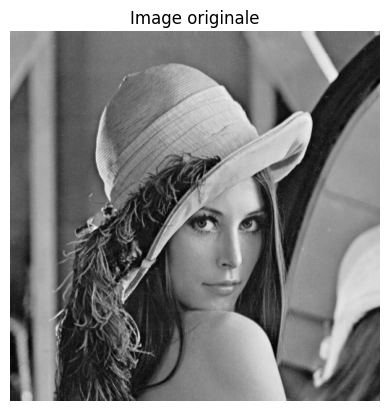

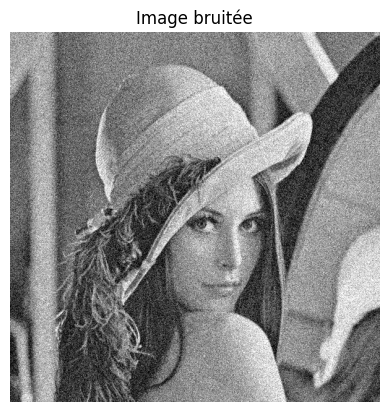

PSNR entre l'image originale et l'image bruitée :  20.070968255566378


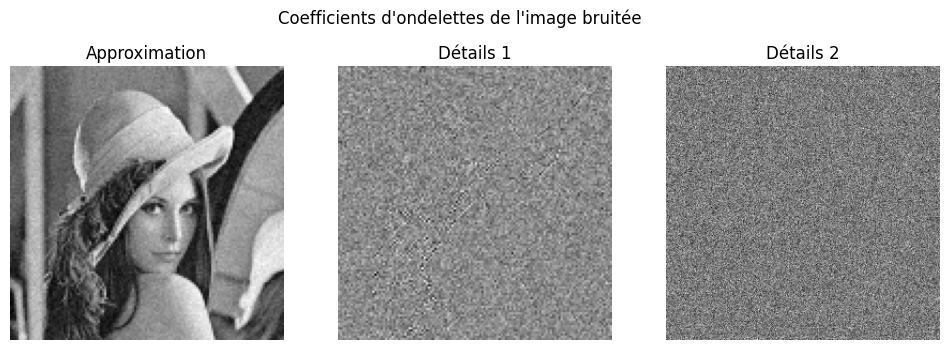

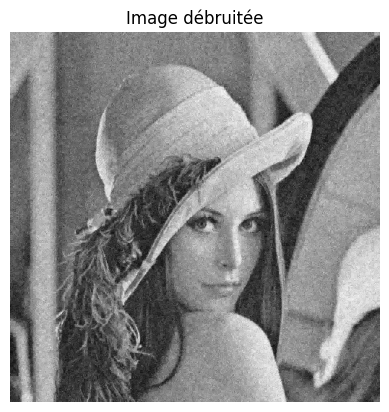

PSNR entre l'image originale et l'image débruitée : 24.6832939070671


In [9]:
image = import_image('lena.pgm')
display_image(image, 'Image originale')

# Bruit
image_noised = ski.util.random_noise(image, mean=0, var=0.01) * 255
image_noised = image_noised.astype(np.uint8)
display_image(image_noised, 'Image bruitée')

psnr_originale_bruitee = psnr(image, image_noised)
print("PSNR entre l'image originale et l'image bruitée : ", psnr_originale_bruitee)

# Transformée sur l'image bruitée
coeffs_noised = apply_wavelet_transform(image_noised)
display_wavelet_coeffs(coeffs_noised, "Coefficients d'ondelettes de l'image bruitée")

# Seuillage
threshold = 20 
coeffs_denoised = apply_wavelet_thresholding(coeffs_noised, threshold)
denoised_image = apply_inverse_wavelet_transform(coeffs_denoised)

denoised_image = normalize_coeffs(denoised_image)
display_image(denoised_image, 'Image débruitée')

ski.io.imsave("results/denoised.pgm", denoised_image)

psnr_originale_debruitee = psnr(image, denoised_image)
print("PSNR entre l'image originale et l'image débruitée :", psnr_originale_debruitee)